In [1]:
import networkx as nx
from networkx.algorithms import approximation, community
import matplotlib.pyplot as plt

In [2]:
def classical_MIS_approach(G, chosen_vertices={}):
    # reduce weights of edges involving a node that has been previously chosen
    reweighted_G = G.copy()
    for i in chosen_vertices:
        for j in reweighted_G.neighbors(i):
            reweighted_G.edges[(i, j)]['weight'] = 0.5
            
    setA, setB = community.kernighan_lin_bisection(reweighted_G)
    cutsetA = set(filter(lambda i: any([j in setB for j in G.neighbors(i)]), setA))
    cutsetB = set(filter(lambda i: any([j in setA for j in G.neighbors(i)]), setB))
    
    subgraphA = nx.subgraph(G, (setA - cutsetA))
    subgraphB = nx.subgraph(G, (setB - cutsetB))
    
    misA = approximation.maximum_independent_set(subgraphA)
    misB = approximation.maximum_independent_set(subgraphB)
    assert len(misA & misB) == 0
    chosen_vertices = misA | misB

    candidates_for_inclusion = set()
    for i in cutsetA | cutsetB:
        if not any([(i, j) in G.edges for j in chosen_vertices]):
            candidates_for_inclusion.add(i)
    setC = nx.subgraph(G, candidates_for_inclusion)
    subgraphC = nx.subgraph(G, setC)
    misC = approximation.maximum_independent_set(subgraphC)
    
    chosen_vertices = chosen_vertices | misC
    
    # ensure chosen_vertices are actually an independent set
    for i in chosen_vertices:
        assert not any([j in chosen_vertices for j in G.neighbors(i)])
    
    return chosen_vertices

In [7]:
NUM_RUNS = 5
NUM_ITERATIONS = 10

def get_plot_data(G, num_runs=NUM_RUNS, num_iterations=NUM_ITERATIONS):
    boppana_halldorsson = len(approximation.maximum_independent_set(G))

    values_list = []
    for _ in range(num_runs):
        values = []
        chosen_vertices = {}
        for _ in range(num_iterations):
            chosen_vertices = classical_MIS_approach(G, chosen_vertices)
            values.append(len(chosen_vertices))
        values_list.append(values)
        
    return boppana_halldorsson, values_list

37 [[37, 33, 37, 37, 37, 35, 39, 38, 38, 37], [37, 35, 34, 38, 35, 38, 40, 35, 38, 34], [36, 37, 37, 36, 35, 34, 38, 37, 38, 37], [36, 36, 36, 39, 39, 37, 39, 39, 38, 33], [39, 38, 36, 38, 37, 41, 34, 41, 34, 36]]


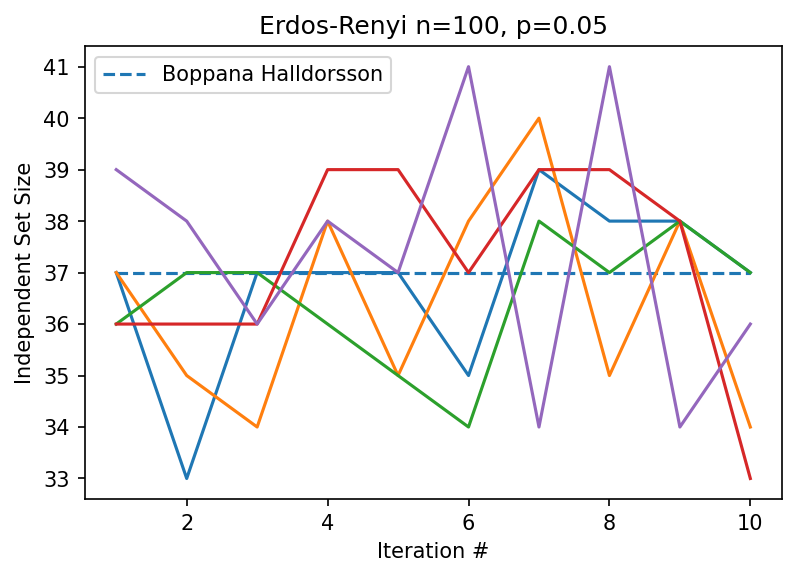

In [12]:
n = 100
p = 0.05

boppana_halldorsson, values_list = get_plot_data(nx.erdos_renyi_graph(n, p))
print(boppana_halldorsson, values_list)

plt.figure(dpi=150)
plt.title(f"Erdos-Renyi n={n}, p={p}"); plt.xlabel("Iteration #"); plt.ylabel("Independent Set Size")
[plt.plot(range(1, NUM_ITERATIONS + 1), values) for values in values_list]
plt.hlines(boppana_halldorsson, 1, NUM_ITERATIONS, linestyles='dashed', label='Boppana Halldorsson')
plt.legend()

73 [[73, 73, 73, 73, 73, 74, 72, 73, 73, 73], [73, 73, 73, 74, 73, 72, 73, 73, 73, 73], [72, 73, 72, 73, 73, 74, 72, 74, 74, 74], [73, 73, 73, 73, 72, 73, 73, 72, 73, 74], [73, 72, 73, 73, 73, 73, 74, 72, 74, 72]]


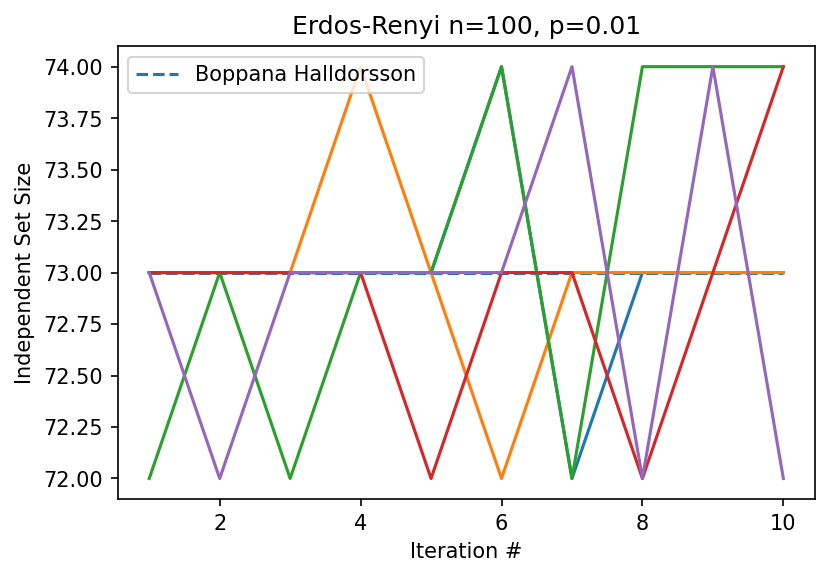

In [14]:
n = 100
p = 0.01

boppana_halldorsson, values_list = get_plot_data(nx.erdos_renyi_graph(n, p))
print(boppana_halldorsson, values_list)

plt.figure(dpi=150)
plt.title(f"Erdos-Renyi n={n}, p={p}"); plt.xlabel("Iteration #"); plt.ylabel("Independent Set Size")
[plt.plot(range(1, NUM_ITERATIONS + 1), values) for values in values_list]
plt.hlines(boppana_halldorsson, 1, NUM_ITERATIONS, linestyles='dashed', label='Boppana Halldorsson')
plt.legend()

13 [[13, 13, 13, 13, 13, 13, 13, 13, 13, 13], [13, 13, 13, 13, 13, 13, 13, 13, 13, 13], [13, 13, 13, 13, 13, 13, 13, 13, 13, 13], [13, 13, 13, 13, 13, 13, 13, 13, 13, 13], [13, 13, 13, 13, 13, 13, 13, 13, 13, 13]]


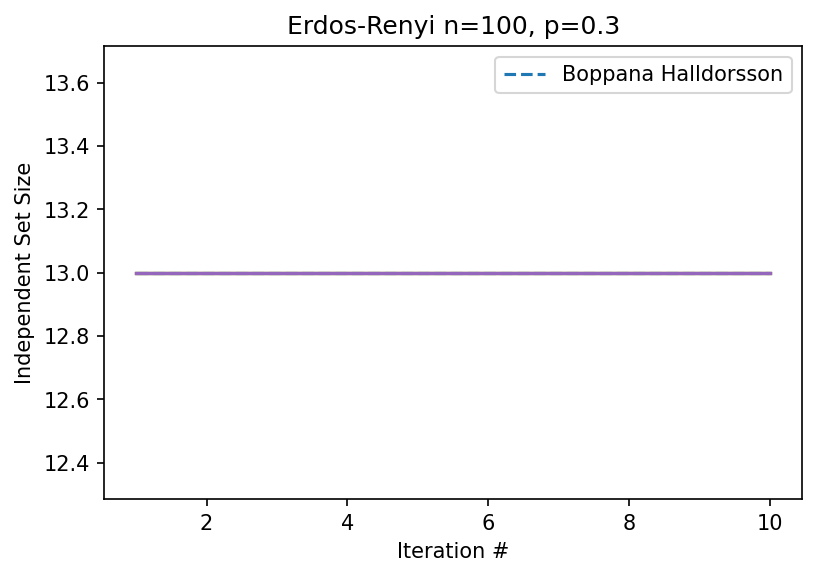

In [15]:
n = 100
p = 0.3

boppana_halldorsson, values_list = get_plot_data(nx.erdos_renyi_graph(n, p))
print(boppana_halldorsson, values_list)

plt.figure(dpi=150)
plt.title(f"Erdos-Renyi n={n}, p={p}"); plt.xlabel("Iteration #"); plt.ylabel("Independent Set Size")
[plt.plot(range(1, NUM_ITERATIONS + 1), values) for values in values_list]
plt.hlines(boppana_halldorsson, 1, NUM_ITERATIONS, linestyles='dashed', label='Boppana Halldorsson')
plt.legend()